# 1. Tarea - Ingeniería de Características Parte 1
* Extracción de columnas NaN y la preparación de data para hacer Complete Case Analysis
* Data Imputation categorícas y continuas
* Codificacion de variables categoricas
* Identificacion y tratamiento de Outliers
* Transformación de Variables (cambio de escala)


In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler


In [76]:
dataHP = pd.read_csv('train_HP.csv')
dataset = dataHP.copy()


In [77]:
def getColumnTypes (dataset):
    '''
    Categoriza las columnas de la dataset en continuas, discretas y categoricas. 
    Output: 3 listas con las columnas categorizadas. 
    '''

    continuas = []
    categoricas = []
    discretas = []


    for col in dataset.columns:
        if col.lower() == 'id':
            continue
        if dataset[col].dtype == 'int64' or dataset[col].dtype == 'float64':
            if dataset[col].nunique() > 30: # si la cantidad distintivos es mayor a 30, se asume que es una variable continua
                continuas.append(col)
            else:
                discretas.append(col)
        else:
            categoricas.append(col)

    return continuas, discretas, categoricas


def plotDensityQQ (dataset, col):
    '''
    Grafica la distribucion y el QQ-Plot de las columnas col de la pandas df dataset
    '''

    plt.figure(figsize=(15,6))

    plt.subplot(1,2,1)
    dataset[col].hist(bins=30)
    plt.title(f'Histograma - {col}')

    plt.subplot(1,2,2)
    stats.probplot(dataset[col], dist='norm', plot=plt)
    plt.title(f'QQ-Plot - {col}')

    plt.show()

def VariableTransformer(dataset, cols):
    '''
    Transforma las variables cols del pandas df dataset para maximizar la normalidad.
    Consideaciones:
        - El algoritmo no garantiza normalidad en todos los casos, solo la aproxima.
        - Solo se aplican 4 transformaciones ditintas: Inversa, cuadratica, boxcox y YeoJhonson
        - Solo aplica una transformacion por variable
    Output: 
        - el dataset transfromado
        - resumen de las transfromaciones realizadas
    '''  
    transformation_summary = pd.DataFrame(columns=['Variable', 'Normalidad', 'Transformada', 'Método'])

    for col in cols:
        shapiro_test = stats.shapiro(dataset[col]).pvalue
        if shapiro_test <= 0.05: # si p es menor a alpha, se rechaza Ho (Ho = la data es normal)
            tag = False
            p_values = [] # Almacenamos los valores p para cada transformación
            transformations = [] # Almacenamos las columnas transformadas
            methods = ['Inversa', 'Cuadratica', 'Boxcox', 'YeoJohnson']
            
            # Método 1 - inversa
            transformed = 1 / dataset[col]
            _, p = stats.shapiro(transformed)
            p_values.append(p)
            transformations.append(transformed)

            # Método 2 - cuadratica
            transformed = dataset[col]**2
            _, p = stats.shapiro(transformed)
            p_values.append(p)
            transformations.append(transformed)

            # Método 3 - boxcox
            transformed, _ = stats.boxcox(dataset[col] + 1e-6) # Evitamos valores de 0
            _, p = stats.shapiro(transformed)
            p_values.append(p)
            transformations.append(transformed)

            # Método 4 - yeojohnson
            transformed, _ = stats.yeojohnson(dataset[col] + 1e-6) # Evitamos valores de 0
            _, p = stats.shapiro(transformed)
            p_values.append(p)
            transformations.append(transformed)

            # Escogemos la transformación con el mayor valor p
            best_transformation_data = transformations[np.argmax(p_values)]
            best_transformation_name = methods[np.argmax(p_values)]
            dataset[col] = best_transformation_data
            

            # Hacemos prueba de normalidad nuevamente
            shapiro_test = stats.shapiro(dataset[col]).pvalue
            if stats.shapiro(dataset[col]).pvalue <= 0.05:
                tag = False
            else:
                tag = True
            
            # Armamos fila con data actualizada
            new_row = pd.Series([col, tag, True, best_transformation_name], index=transformation_summary.columns)

        else:
            tag = True
            new_row = pd.Series([col, tag, False, np.NaN], index=transformation_summary.columns)
        
        transformation_summary = transformation_summary.append(new_row, ignore_index=True)
    return dataset, transformation_summary




def fill_missing_cats(dataset, target_column):
    '''
    Se seleccionan todas las varialbes categoricas para tratar los valores nulos respecto a la variable respuesta. 
    Si los valores nulos tienen una distribucion diferente a las demas categorias, los nulos se vuelven una categoria mas.
    De lo contrario, los valores nulos se sustituyen por la categoria con la distribucion mas parecida.
    Se utiliza una prueba T student con difernecia de medias suponiendo varianzas iguales entre los nulos y las demas categorias.
    Output: database con los nulos tratados   
    '''
    # Iteramos sobre todas las columnas del dataset
    for col in dataset.columns:
        # Si la columna es categórica
        if dataset[col].dtype == 'object':
            # Si hay nulos en la columna
            if dataset[col].isnull().any():
                # Guardamos los valores de la variable dependiente para los nulos
                null_values = dataset[dataset[col].isnull()][target_column]

                # Calculamos el p-valor de la prueba t para cada categoría
                p_values = {category: stats.ttest_ind(null_values, dataset[dataset[col] == category][target_column], equal_var=False, nan_policy='omit').pvalue for category in dataset[col].unique() if category is not np.nan}

                # Si todos los p-valores son menores que 0.05, sustituimos los nulos con 'Missing'
                if all(p < 0.05 for p in p_values.values()):
                    dataset[col].fillna('Missing', inplace=True)
                else:
                    # Si no, sustituimos los nulos con la categoría más similar (el mayor p-valor)
                    similar_category = max(p_values, key=p_values.get)
                    dataset[col].fillna(similar_category, inplace=True)

    return dataset



def outlierLimits (df, col):
    '''
    Calcula los limites inferiores y superiores en base al criterio de IQR
    df: pandas dataframe
    col: pandas dataframe column
    '''
    IQR = dataset[col].quantile(0.75) - dataset[col].quantile(0.25)
    LI =  dataset[col].quantile(0.25) - (IQR*1.75)
    LS =  dataset[col].quantile(0.75) + (IQR*1.75)
    return LI, LS




In [78]:
continuas, discretas, categoricas = getColumnTypes(dataset) # se separan todas las columnas en base a su tipo

for i in [continuas, discretas, categoricas]:
    print(len(i))

19
18
43


## Tratamiento datos nulos

In [79]:
nan_proporcion =  dataset.isnull().mean()
nan_proporcion = nan_proporcion[lambda x: x>0]
nan_proporcion

LotFrontage     0.177397
Alley           0.937671
MasVnrType      0.005479
MasVnrArea      0.005479
BsmtQual        0.025342
BsmtCond        0.025342
BsmtExposure    0.026027
BsmtFinType1    0.025342
BsmtFinType2    0.026027
Electrical      0.000685
FireplaceQu     0.472603
GarageType      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
GarageQual      0.055479
GarageCond      0.055479
PoolQC          0.995205
Fence           0.807534
MiscFeature     0.963014
dtype: float64

### Variables categoricas

In [80]:
fill_missing_cats(dataset, 'SalePrice')

C:\Users\juanj\AppData\Local\Temp\ipykernel_48060\3698695238.py:132: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  p_values = {category: stats.ttest_ind(null_values, dataset[dataset[col] == category][target_column], equal_var=False, nan_policy='omit').pvalue for category in dataset[col].unique() if category is not np.nan}
c:\Users\juanj\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
c:\Users\juanj\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1214: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Missing,Reg,Lvl,AllPub,...,0,Gd,GdPrv,Gar2,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Missing,Reg,Lvl,AllPub,...,0,Gd,GdPrv,Gar2,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,Missing,IR1,Lvl,AllPub,...,0,Gd,GdPrv,Gar2,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,Missing,IR1,Lvl,AllPub,...,0,Gd,GdPrv,Gar2,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,Missing,IR1,Lvl,AllPub,...,0,Gd,GdPrv,Gar2,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,Missing,Reg,Lvl,AllPub,...,0,Gd,GdPrv,Gar2,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,Missing,Reg,Lvl,AllPub,...,0,Gd,MnPrv,Gar2,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,Missing,Reg,Lvl,AllPub,...,0,Gd,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,Missing,Reg,Lvl,AllPub,...,0,Gd,GdPrv,Gar2,0,4,2010,WD,Normal,142125


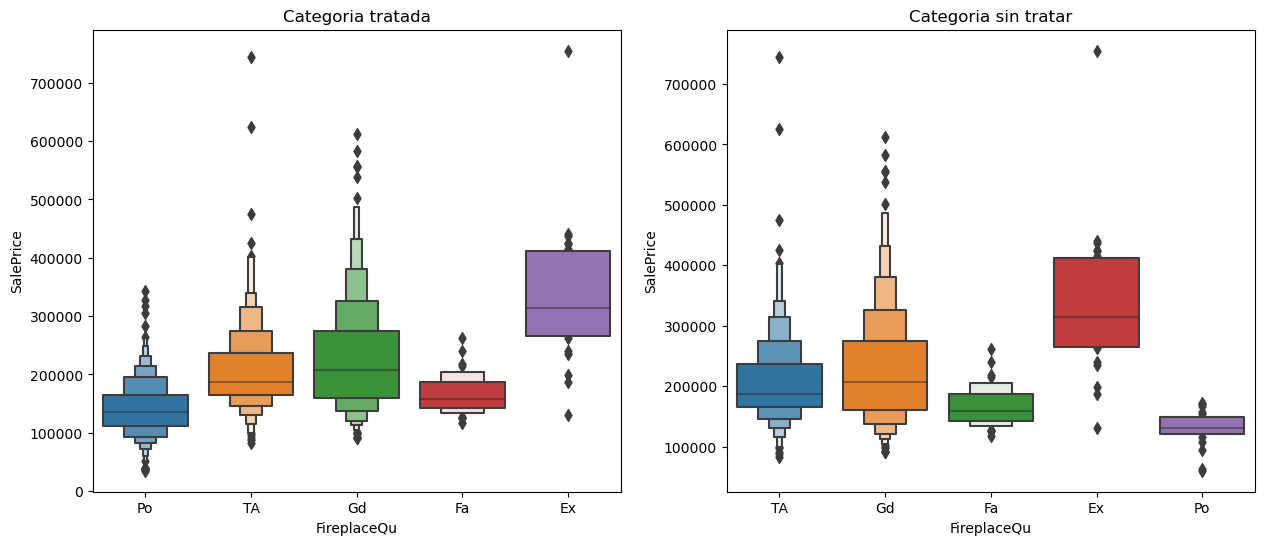

In [81]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
sns.boxenplot(x=dataset['FireplaceQu'], y=dataHP['SalePrice'])
plt.title('Categoria tratada')

plt.subplot(1,2,2)
sns.boxenplot(x=dataHP['FireplaceQu'], y=dataHP['SalePrice'])
plt.title(f'Categoria sin tratar')
plt.show()


### Identifiacion y tratamiento de Outliers

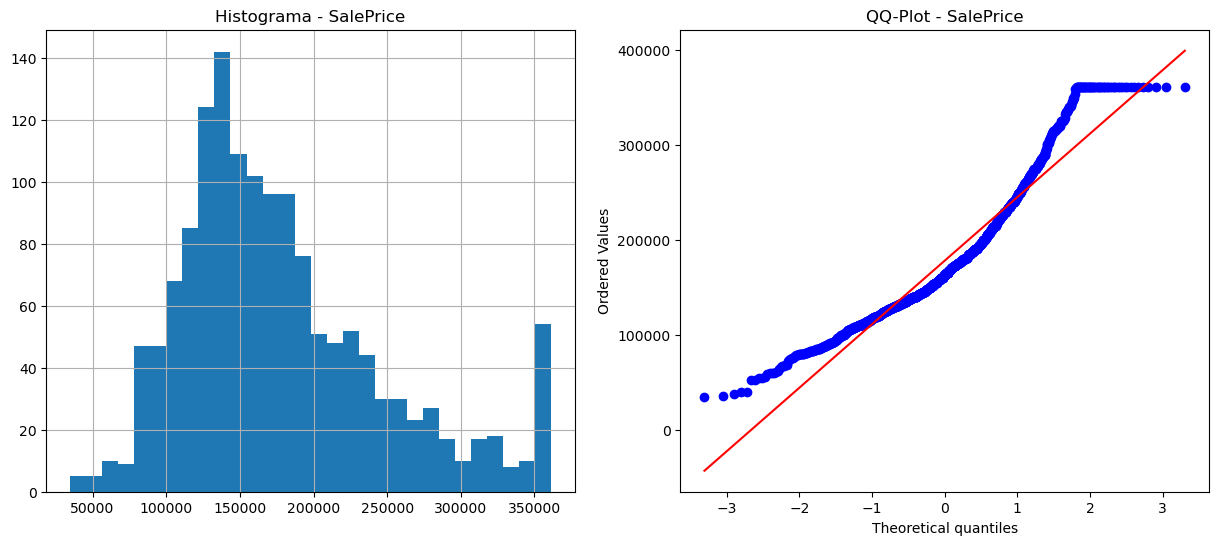

In [82]:
for col in continuas: 
    LI, LS = outlierLimits(dataset, col)
    dataset[col] = np.where(dataset[col] > LS, LS, np.where(dataset[col] < LI, 0, dataset[col] )) # Se sustituye todo lo que esta fuera de limites al valor de los limites

plotDensityQQ(dataset, col)

### Imputacion media para variables restantes

In [83]:
nan_proporcion =  dataset.isnull().mean()
nan_proporcion = nan_proporcion[lambda x: x>0]
nan_proporcion
dataset = dataset.fillna(dataset.median())

LotFrontage    0.177397
MasVnrArea     0.005479
GarageYrBlt    0.055479
dtype: float64

## Codificacion de variables categoricas

In [84]:
for cat in categoricas:
    temp_freqs = dataset[cat].value_counts(normalize=True).to_dict()
    dataset[f'{cat}_code'] = dataset[cat].map(temp_freqs)


dataset[['KitchenQual', 'KitchenQual_code']]


,KitchenQual,KitchenQual_code
0,Gd,0.401370
1,TA,0.503425
2,Gd,0.401370
3,Gd,0.401370
4,Gd,0.401370
...,...,...
1455,TA,0.503425
1456,TA,0.503425
1457,Gd,0.401370
1458,Gd,0.401370


## Transformacion de variables, Normalizacion y Escalamiento

C:\Users\juanj\AppData\Local\Temp\ipykernel_48060\3698695238.py:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transformation_summary = transformation_summary.append(new_row, ignore_index=True)
C:\Users\juanj\AppData\Local\Temp\ipykernel_48060\3698695238.py:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transformation_summary = transformation_summary.append(new_row, ignore_index=True)
C:\Users\juanj\AppData\Local\Temp\ipykernel_48060\3698695238.py:108: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  transformation_summary = transformation_summary.append(new_row, ignore_index=True)
C:\Users\juanj\AppData\Local\Temp\ipykernel_48060\3698695238.py:108: FutureWarning: The frame.appen

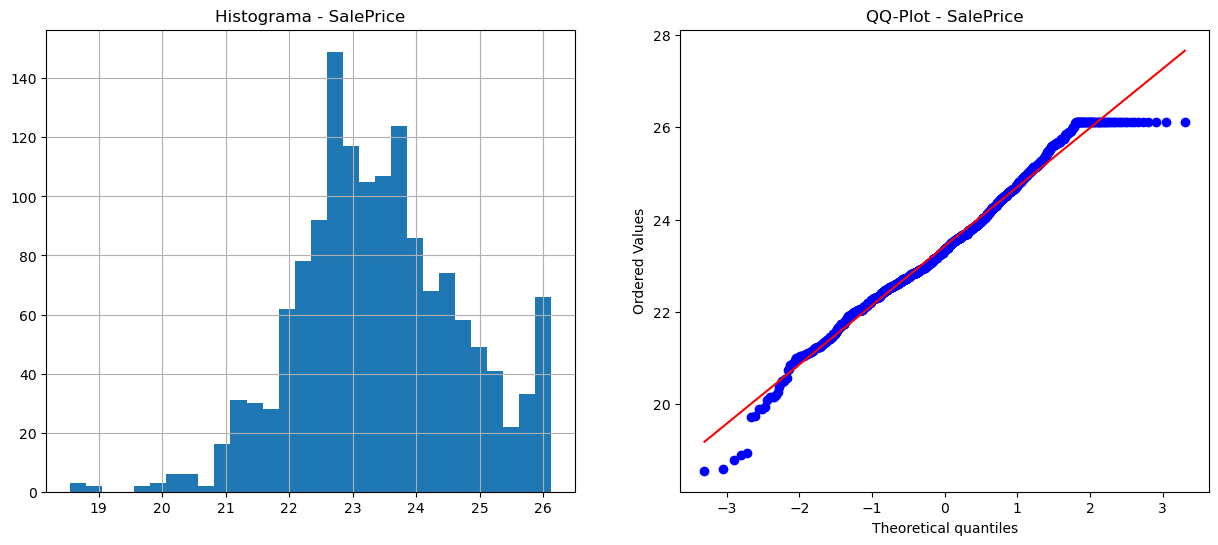

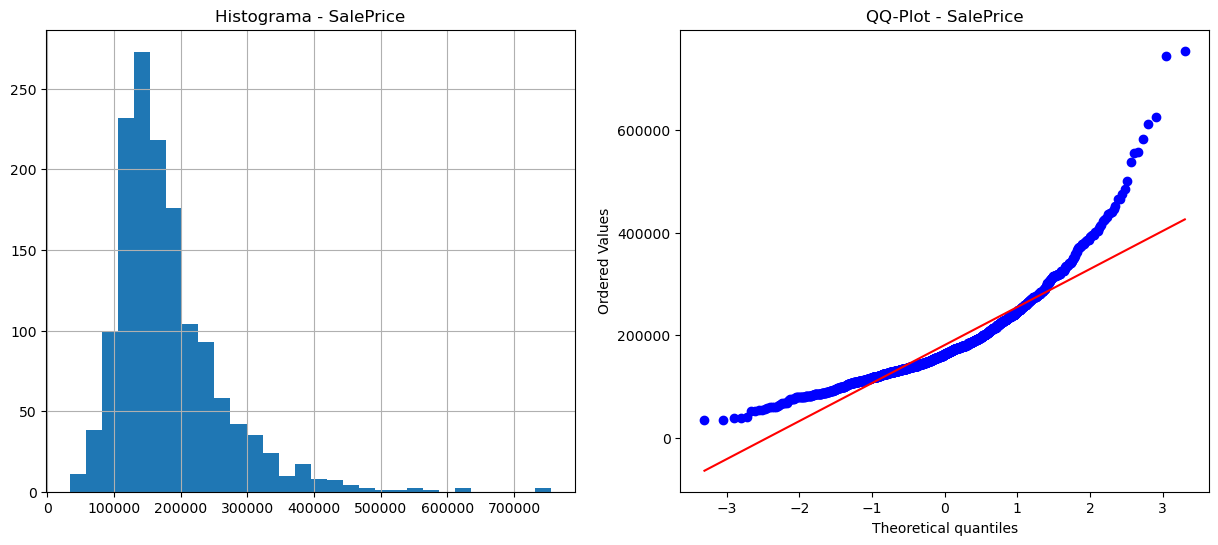

In [85]:
dataset_final, summary = VariableTransformer(dataset, continuas)

plotDensityQQ(dataset_final, 'SalePrice')
plotDensityQQ(dataHP, 'SalePrice')

In [86]:
dataset.mean()

C:\Users\juanj\AppData\Local\Temp\ipykernel_48060\1799472221.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  dataset.mean()


Id                     730.500000
MSSubClass              56.897260
LotFrontage             68.741257
LotArea               1490.090683
OverallQual              6.099315
                         ...     
PoolQC_code              0.994532
Fence_code               0.731999
MiscFeature_code         0.931164
SaleType_code            0.761016
SaleCondition_code       0.685677
Length: 81, dtype: float64

In [87]:
scaler = StandardScaler()
scaler.fit(dataset[continuas]) # se extrae info interna (parametros) para transformaciones posteriores. En este caso son la media y la std
dataHP_scaled = scaler.transform(dataset[continuas])
dataHP_scaled = pd.DataFrame(dataHP_scaled, columns=continuas)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
 

ax1.set_title("Sin Escala")
sns.kdeplot(dataHP['LotFrontage'], ax=ax1, label="LotFrontage")
sns.kdeplot(dataHP['SalePrice'], ax=ax1, label="SalePrice")

 

ax2.set_title("Con Escala")
sns.kdeplot(dataHP_scaled['LotFrontage'], ax=ax2, label="LotFrontage")
sns.kdeplot(dataHP_scaled['SalePrice'], ax=ax2, label="SalePrice")
 

ax1.legend()
ax2.legend()


plt.show()

ValueError: Input X contains infinity or a value too large for dtype('float64').